In [ ]:
print("🔗 Connexion à Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive monté avec succès")

import os
from pathlib import Path

print("\n📁 Configuration des chemins de travail...")

# Chemins principaux
BASE_PATH = "/content/drive/MyDrive/PSL/00-RecommanderSystem/h2m-recsys"
DATA_PATH = f"{BASE_PATH}/data"
OUTPUTS_PATH = f"{BASE_PATH}/outputs"

🔗 Connexion à Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive monté avec succès

📁 Configuration des chemins de travail...


# 🔧 Préparation des Données pour LightFM

**Objectif :** Transformer les données H&M en format LightFM
- Mappings entiers pour users/items
- Matrice sparse interactions
- Features articles structurées
- Split train/test temporel

---

## 📁 CHARGEMENT DES ÉCHANTILLONS


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

print("📊 Chargement des échantillons...")


# Chargement données
with open(f"{OUTPUTS_PATH}/sampling_results.pkl", "rb") as f:
    sampling_data = pickle.load(f)

df_sample = sampling_data['echantillon_principal']['data'].copy()
df_test_sample = sampling_data['echantillon_test']['data'].copy()

with open(f"{OUTPUTS_PATH}/datasets_complets.pkl", "rb") as f:
    full_data = pickle.load(f)
df_articles = full_data['articles']

print(f"✅ Échantillon chargé: {len(df_sample):,} interactions")

📊 Chargement des échantillons...
✅ Échantillon chargé: 10,000 interactions


## 🔢 CRÉATION DES MAPPINGS ENTIERS

In [ ]:
print("\n" + "="*60)
print("🔢 CRÉATION DES MAPPINGS USER/ITEM → ENTIERS")
print("="*60)

class IDMapper:
    """Classe pour mapper IDs vers entiers et vice-versa"""

    def __init__(self, ids):
        self.id_to_idx = {id_val: idx for idx, id_val in enumerate(sorted(ids))}
        self.idx_to_id = {idx: id_val for id_val, idx in self.id_to_idx.items()}
        self.n_items = len(self.id_to_idx)

    def map_to_idx(self, ids):
        return [self.id_to_idx.get(id_val, -1) for id_val in ids]

    def map_to_id(self, indices):
        return [self.idx_to_id.get(idx, None) for idx in indices]

# Création des mappers
unique_users = df_sample['customer_id'].unique()
unique_items = df_sample['article_id'].unique()

user_mapper = IDMapper(unique_users)
item_mapper = IDMapper(unique_items)

print(f"👥 Users: {user_mapper.n_items:,} uniques")
print(f"🎽 Items: {item_mapper.n_items:,} uniques")

# Application des mappings
df_sample['user_idx'] = user_mapper.map_to_idx(df_sample['customer_id'])
df_sample['item_idx'] = item_mapper.map_to_idx(df_sample['article_id'])

# Vérification
assert not any(idx == -1 for idx in df_sample['user_idx']), "Erreur mapping users"
assert not any(idx == -1 for idx in df_sample['item_idx']), "Erreur mapping items"

print("✅ Mappings créés et appliqués")


🔢 CRÉATION DES MAPPINGS USER/ITEM → ENTIERS
👥 Users: 9,848 uniques
🎽 Items: 7,837 uniques
✅ Mappings créés et appliqués


## ⏰ SPLIT TEMPOREL TRAIN/TEST

In [ ]:
print("\n" + "="*60)
print("⏰ CRÉATION DU SPLIT TEMPOREL")
print("="*60)

# Conversion date
df_sample['t_dat'] = pd.to_datetime(df_sample['t_dat'])
date_min = df_sample['t_dat'].min()
date_max = df_sample['t_dat'].max()
duree_jours = (date_max - date_min).days

# Split 80/20 temporel
split_date = date_min + pd.Timedelta(days=int(duree_jours * 0.8))

train_data = df_sample[df_sample['t_dat'] < split_date].copy()
test_data = df_sample[df_sample['t_dat'] >= split_date].copy()

print(f"📅 Période totale: {date_min.date()} → {date_max.date()} ({duree_jours} jours)")
print(f"📅 Split date: {split_date.date()}")
print(f"🚂 Train: {len(train_data):,} interactions ({len(train_data)/len(df_sample)*100:.1f}%)")
print(f"🧪 Test:  {len(test_data):,} interactions ({len(test_data)/len(df_sample)*100:.1f}%)")

# Vérification overlap users/items
train_users = set(train_data['user_idx'])
test_users = set(test_data['user_idx'])
train_items = set(train_data['item_idx'])
test_items = set(test_data['item_idx'])

user_overlap = len(train_users & test_users) / len(test_users) * 100
item_overlap = len(train_items & test_items) / len(test_items) * 100

print(f"👥 Overlap users: {user_overlap:.1f}% (test users présents dans train)")
print(f"🎽 Overlap items: {item_overlap:.1f}% (test items présents dans train)")


⏰ CRÉATION DU SPLIT TEMPOREL
📅 Période totale: 2018-09-20 → 2020-09-22 (733 jours)
📅 Split date: 2020-04-28
🚂 Train: 7,947 interactions (79.5%)
🧪 Test:  2,053 interactions (20.5%)
👥 Overlap users: 2.1% (test users présents dans train)
🎽 Overlap items: 15.5% (test items présents dans train)


## 🔗 CONSTRUCTION MATRICE SPARSE INTERACTIONS


In [ ]:

print("\n" + "="*60)
print("🔗 CONSTRUCTION MATRICE SPARSE")
print("="*60)

def create_interaction_matrix(df, n_users, n_items):
    """Crée matrice sparse user-item"""

    # Valeurs binaires (1 = interaction)
    data = np.ones(len(df))
    row = df['user_idx'].values
    col = df['item_idx'].values

    # Matrice COO puis CSR
    matrix_coo = coo_matrix((data, (row, col)), shape=(n_users, n_items))
    matrix_csr = matrix_coo.tocsr()

    return matrix_csr

# Matrices train/test
train_matrix = create_interaction_matrix(train_data, user_mapper.n_items, item_mapper.n_items)
test_matrix = create_interaction_matrix(test_data, user_mapper.n_items, item_mapper.n_items)

print(f"🚂 Matrice train: {train_matrix.shape} - {train_matrix.nnz:,} interactions")
print(f"🧪 Matrice test:  {test_matrix.shape} - {test_matrix.nnz:,} interactions")
print(f"💾 Sparsité train: {1 - train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1]):.4f}")


🔗 CONSTRUCTION MATRICE SPARSE
🚂 Matrice train: (9848, 7837) - 7,947 interactions
🧪 Matrice test:  (9848, 7837) - 2,052 interactions
💾 Sparsité train: 0.9999


## 🏷️ PRÉPARATION FEATURES ARTICLES


In [ ]:

print("\n" + "="*60)
print("🏷️ CRÉATION FEATURES ARTICLES")
print("="*60)

# Sélection features pertinentes
feature_columns = [
    'product_group_name', 'colour_group_name', 'department_name',
    'index_group_name', 'section_name', 'garment_group_name'
]

# Filtrage articles présents dans échantillon
articles_in_sample = df_articles[df_articles['article_id'].isin(unique_items)].copy()
print(f"📦 Articles avec features: {len(articles_in_sample):,}")

# Nettoyage features
for col in feature_columns:
    if col in articles_in_sample.columns:
        articles_in_sample[col] = articles_in_sample[col].fillna('Unknown')

# Encodage des features
def encode_categorical_features(df, feature_cols):
    """Encode features catégorielles en format sparse"""

    encoded_features = {}
    feature_matrices = []
    feature_names = []

    for col in feature_cols:
        if col not in df.columns:
            continue

        # LabelEncoder pour cette feature
        le = LabelEncoder()
        encoded_col = le.fit_transform(df[col].astype(str))

        # Matrice binaire one-hot
        n_categories = len(le.classes_)
        feature_matrix = np.zeros((len(df), n_categories))
        feature_matrix[np.arange(len(df)), encoded_col] = 1

        feature_matrices.append(feature_matrix)
        feature_names.extend([f"{col}_{cls}" for cls in le.classes_])

        encoded_features[col] = {
            'encoder': le,
            'n_categories': n_categories,
            'classes': le.classes_
        }

    # Concaténation toutes features
    if feature_matrices:
        all_features_matrix = np.hstack(feature_matrices)
        return all_features_matrix, feature_names, encoded_features
    else:
        return None, [], {}

# Application encodage
articles_features, feature_names, feature_encoders = encode_categorical_features(
    articles_in_sample, feature_columns
)

if articles_features is not None:
    print(f"🔢 Features matrix: {articles_features.shape}")
    print(f"🏷️ Feature names: {len(feature_names)} total")

    # Création mapping article_id → feature row
    article_to_row = {
        article_id: idx
        for idx, article_id in enumerate(articles_in_sample['article_id'])
    }
else:
    print("❌ Aucune feature créée")


🏷️ CRÉATION FEATURES ARTICLES
📦 Articles avec features: 7,837
🔢 Features matrix: (7837, 345)
🏷️ Feature names: 345 total


## 📊 ANALYSE DE LA PRÉPARATION



📊 ANALYSE DES DONNÉES PRÉPARÉES


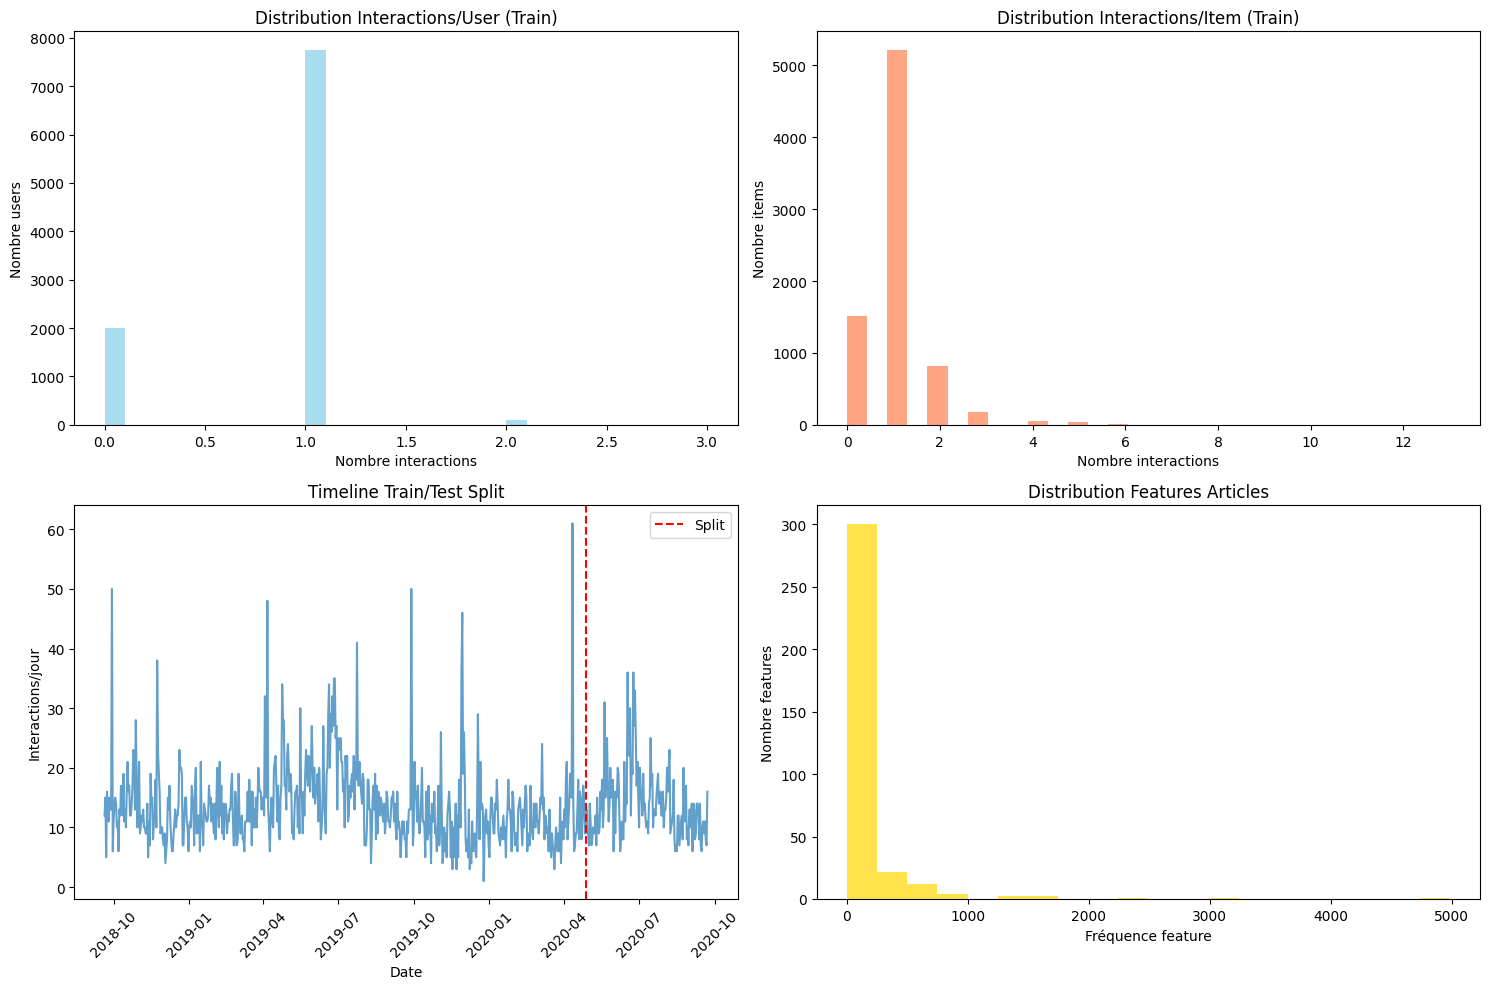


📊 STATISTIQUES FINALES:
   • Users actifs train: 7,845
   • Items actifs train: 6,324
   • Interactions/user moyen: 0.81
   • Interactions/item moyen: 1.01


In [ ]:

print("\n" + "="*60)
print("📊 ANALYSE DES DONNÉES PRÉPARÉES")
print("="*60)

# Stats distributions
train_user_counts = np.array(train_matrix.sum(axis=1)).flatten()
train_item_counts = np.array(train_matrix.sum(axis=0)).flatten()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution users train
axes[0,0].hist(train_user_counts, bins=30, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribution Interactions/User (Train)')
axes[0,0].set_xlabel('Nombre interactions')
axes[0,0].set_ylabel('Nombre users')

# Distribution items train
axes[0,1].hist(train_item_counts, bins=30, alpha=0.7, color='coral')
axes[0,1].set_title('Distribution Interactions/Item (Train)')
axes[0,1].set_xlabel('Nombre interactions')
axes[0,1].set_ylabel('Nombre items')

# Timeline split
timeline_data = df_sample.groupby(df_sample['t_dat'].dt.date).size()
axes[1,0].plot(timeline_data.index, timeline_data.values, alpha=0.7)
axes[1,0].axvline(split_date.date(), color='red', linestyle='--', label='Split')
axes[1,0].set_title('Timeline Train/Test Split')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Interactions/jour')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# Features distribution
if articles_features is not None:
    feature_sums = articles_features.sum(axis=0)
    axes[1,1].hist(feature_sums, bins=20, alpha=0.7, color='gold')
    axes[1,1].set_title('Distribution Features Articles')
    axes[1,1].set_xlabel('Fréquence feature')
    axes[1,1].set_ylabel('Nombre features')

plt.tight_layout()
plt.savefig(f"{OUTPUTS_PATH}/figures/data_preparation_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Stats finales
print(f"\n📊 STATISTIQUES FINALES:")
print(f"   • Users actifs train: {(train_user_counts > 0).sum():,}")
print(f"   • Items actifs train: {(train_item_counts > 0).sum():,}")
print(f"   • Interactions/user moyen: {train_user_counts.mean():.2f}")
print(f"   • Interactions/item moyen: {train_item_counts.mean():.2f}")

## 💾 SAUVEGARDE DONNÉES PRÉPARÉES


In [ ]:
print("\n💾 Sauvegarde des données préparées...")

# Structures à sauvegarder
prepared_data = {
    'matrices': {
        'train': train_matrix,
        'test': test_matrix
    },
    'mappings': {
        'user_mapper': user_mapper,
        'item_mapper': item_mapper
    },
    'features': {
        'item_features_matrix': articles_features,
        'feature_names': feature_names,
        'feature_encoders': feature_encoders,
        'article_to_row_mapping': article_to_row if articles_features is not None else None
    },
    'dataframes': {
        'train_df': train_data,
        'test_df': test_data,
        'articles_features_df': articles_in_sample
    },
    'metadata': {
        'n_users': user_mapper.n_items,
        'n_items': item_mapper.n_items,
        'n_train_interactions': train_matrix.nnz,
        'n_test_interactions': test_matrix.nnz,
        'train_sparsity': 1 - train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1]),
        'split_date': split_date.isoformat(),
        'feature_dims': articles_features.shape if articles_features is not None else None,
        'preparation_date': datetime.now().isoformat()
    }
}

# Sauvegarde
with open(f"{OUTPUTS_PATH}/prepared_data.pkl", "wb") as f:
    pickle.dump(prepared_data, f)

print(f"✅ Données préparées sauvegardées")
print(f"   • Matrices sparse: train {train_matrix.shape}, test {test_matrix.shape}")
print(f"   • Features: {articles_features.shape if articles_features is not None else 'None'}")
print(f"   • Mappings: {user_mapper.n_items} users, {item_mapper.n_items} items")


💾 Sauvegarde des données préparées...
✅ Données préparées sauvegardées
   • Matrices sparse: train (9848, 7837), test (9848, 7837)
   • Features: (7837, 345)
   • Mappings: 9848 users, 7837 items


## 🎯 RÉSUMÉ ET PROCHAINES ÉTAPES


In [ ]:

print("\n" + "="*70)
print("🎯 DONNÉES PRÊTES POUR LIGHTFM")
print("="*70)

print(f"\n📊 STRUCTURES CRÉÉES:")
print(f"   • Matrice train: {train_matrix.shape} ({train_matrix.nnz:,} interactions)")
print(f"   • Matrice test: {test_matrix.shape} ({test_matrix.nnz:,} interactions)")
print(f"   • Features items: {articles_features.shape if articles_features is not None else 'Aucune'}")
print(f"   • Mappings: Users/Items → entiers")

print(f"\n🚀 PRÊT POUR:")
print(f"   1. Modèle collaboratif LightFM (train_matrix)")
print(f"   2. Évaluation sur test_matrix")
print(f"   3. Modèle hybride avec features articles")

print("\n✅ Préparation terminée - Data prête pour LightFM!")
print("="*70)


🎯 DONNÉES PRÊTES POUR LIGHTFM

📊 STRUCTURES CRÉÉES:
   • Matrice train: (9848, 7837) (7,947 interactions)
   • Matrice test: (9848, 7837) (2,052 interactions)
   • Features items: (7837, 345)
   • Mappings: Users/Items → entiers

🚀 PRÊT POUR:
   1. Modèle collaboratif LightFM (train_matrix)
   2. Évaluation sur test_matrix
   3. Modèle hybride avec features articles

✅ Préparation terminée - Data prête pour LightFM!
